# DOS detection using Deep learning models

In [126]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [127]:
# Loading the dataset
dataset = pd.read_csv('/kaggle/input/network-traffic-for-dos-detection/dataset.csv')

## Data preprocessing

In [128]:
dataset.head()

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket
0,0,38.57.146.249,True,12,notification,2022-01-02T03:31:34.498Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
3,3,228.143.56.163,True,12,notification,2022-01-02T03:44:36.548Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,2616,1416.003662,154.615479,1045.380831,12,999,100.0,19.867088,97.914746,Delay-insensitive,8,56.0


In [129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187087 entries, 0 to 187086
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Id                         187087 non-null  int64  
 1   IP                         187087 non-null  object 
 2   bot                        187087 non-null  bool   
 3   FunctionId                 187087 non-null  int64  
 4   functionTrigger            187087 non-null  object 
 5   timestamp                  187087 non-null  object 
 6   SubmitTime                 187087 non-null  int64  
 7   RTT                        187087 non-null  int64  
 8   InvocationDelay            187087 non-null  float64
 9   ResponseDelay              187087 non-null  float64
 10  FunctionDuration           187087 non-null  float64
 11  ActiveFunctionsAtRequest   187087 non-null  int64  
 12  ActiveFunctionsAtResponse  187087 non-null  int64  
 13  maxcpu                     18

In [130]:
dataset.shape

(187087, 19)

In [131]:
dataset.describe()

,Id,FunctionId,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket
count,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000,187087.000000
mean,93543.000000,28.592569,85.841250,2494.167083,1239.287586,165.658396,1089.373666,28.592569,996.465741,97.050470,31.440571,88.441047,4.776297,31.000653
std,54007.509243,13.777358,11.968575,286.236688,299.874337,42.838260,62.326101,13.777358,3.010734,5.018163,17.386644,20.042926,3.489087,27.057633
min,0.000000,2.000000,71.000000,1373.000000,170.746338,117.803711,1031.168938,2.000000,988.000000,78.776399,1.350084,7.924250,1.000000,0.750000
25%,46771.500000,17.000000,75.000000,2344.000000,1060.574707,134.759521,1059.582233,17.000000,994.000000,96.017207,19.830185,89.853209,1.000000,1.750000
50%,93543.000000,30.000000,79.000000,2476.000000,1205.249512,145.178711,1074.904203,30.000000,998.000000,99.356190,33.304020,95.297275,8.000000,56.000000
75%,140314.500000,40.000000,98.000000,2593.000000,1388.304443,203.505127,1099.621534,40.000000,999.000000,99.566656,41.804117,98.110481,8.000000,56.000000
max,187086.000000,50.000000,102.000000,3019.000000,1800.190674,247.116455,1437.139511,50.000000,999.000000,100.000000,92.503412,99.586511,8.000000,56.000000


In [132]:
dataset.isnull()

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,FunctionDuration,ActiveFunctionsAtRequest,ActiveFunctionsAtResponse,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187082,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
187083,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
187084,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
187085,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [133]:
dataset.isnull().sum()

Id                           0
IP                           0
bot                          0
FunctionId                   0
functionTrigger              0
timestamp                    0
SubmitTime                   0
RTT                          0
InvocationDelay              0
ResponseDelay                0
FunctionDuration             0
ActiveFunctionsAtRequest     0
ActiveFunctionsAtResponse    0
maxcpu                       0
avgcpu                       0
p95maxcpu                    0
vmcategory                   0
vmcorecountbucket            0
vmmemorybucket               0
dtype: int64

### Feature Selection

In building machine learning models, selecting the appropriate features from the dataset to use in the training and prediction abilities of the model is crucial for the model's performance and interpretability. Here, we select relevant features to be used as input variables for our model.

#### Selected Features:
- `InvocationDelay`: Time delay between the invocation and response of a function.
- `ResponseDelay`: Delay in the response time of a function.
- `FunctionDuration`: Duration of the function execution.
- `maxcpu`: Maximum CPU usage.
- `avgcpu`: Average CPU usage.
- `p95maxcpu`: 95th percentile of the maximum CPU usage.

#### Additional Features:
- `SubmitTime`: Timestamp of when the request was submitted.
- `RTT`: Round-Trip Time, i.e., the time taken for a signal to travel to a destination and back.
- `ActiveFunctionsAtRequest`: Number of active functions at the time of request.
- `ActiveFunctionsAtResponse`: Number of active functions at the time of response.

These features are chosen based on their potential relevance to the detection of Denial-of-Service (DoS) attacks, assuming that the 'bot' column represents the binary label indicating the presence or absence of such attacks.


In [134]:
# Select relevant features
selected_features = ['InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'maxcpu', 'avgcpu', 'p95maxcpu']
additional_features = ['SubmitTime', 'RTT', 'ActiveFunctionsAtRequest', 'ActiveFunctionsAtResponse']
X = dataset[selected_features + additional_features]
y = dataset['bot']  

### Feature Engineering

Feature engineering is the process of transforming raw data into a more suitable format for machine learning algorithms. In this context, we are enhancing the dataset by extracting additional time-related features from the timestamp column.

#### Procedure:

1. **Timestamp Conversion**: Initially, we convert the timestamp column into datetime format. This conversion aids in the extraction of time-based features.

2. **Extraction of Time-Based Features**:
   - `HourOfDay`: We derive the hour of the day from the timestamp.
   - `DayOfWeek`: The day of the week is extracted from the timestamp.

These newly engineered features allow for a deeper understanding of temporal patterns within the data, which could be instrumental in identifying patterns associated with Denial-of-Service (DoW) attacks.



In [135]:
X = dataset.copy()

# Convert timestamp to datetime format
X['timestamp'] = X['timestamp'].apply(lambda x: pd.to_datetime(x, format='mixed', utc=True))

# Extract time-based features
X['HourOfDay'] = X['timestamp'].dt.hour
X['DayOfWeek'] = X['timestamp'].dt.dayofweek

### Interaction Features

Interaction features are generated by combining or interacting multiple existing features to capture potential relationships or interactions among them. In this context, we create interaction features using specific columns from the dataset.

#### Procedure:

1. **Interaction1**: We multiply the values in the 'InvocationDelay' column by those in the 'ResponseDelay' column, resulting in a new interaction feature named 'Interaction1'.
   
2. **Interaction2**: Another interaction feature, 'Interaction2', is created by dividing the values in the 'maxcpu' column by those in the 'avgcpu' column.

These interaction features aim to capture potential synergies or dependencies among the designated columns, which could enhance the model's performance by incorporating additional insights from the data.



In [136]:
# 2. Interaction features
X['Interaction1'] = X['InvocationDelay'] * X['ResponseDelay']
X['Interaction2'] = X['maxcpu'] / X['avgcpu']

### Statistical Features

Statistical features offer insights into attribute distributions and variabilities across distinct groups or categories. These features are computed through group-wise operations on the dataset, particularly focusing on attribute behavior concerning unique IP addresses.

1. **RTT_mean**: This feature signifies the average Round-Trip Time (RTT) observed per unique IP address. RTT, a critical metric in network communications, reflects the time taken for a signal to travel from sender to receiver and back. Calculating the mean RTT per IP address provides an understanding of the typical communication latency experienced by devices linked to that IP.

2. **RTT_std**: The standard deviation of RTT indicates the variability or spread in RTT values across different instances associated with the same IP address. A higher standard deviation implies greater variability in communication latencies, which may suggest fluctuating network conditions or diverse traffic types handled by the IP.

3. **InvocationDelay_mean**: This feature represents the average Invocation Delay observed for each unique IP address. Invocation Delay signifies the time interval between initiating a function invocation and its actual execution. Computing the mean Invocation Delay per IP address offers insights into the typical processing latency experienced by functions triggered from devices linked to that IP.

4. **InvocationDelay_std**: Analogous to RTT_std, InvocationDelay_std denotes the standard deviation of Invocation Delay values across instances associated with the same IP address. A higher standard deviation indicates greater variability in processing latencies, potentially influenced by factors like varying workload demands or resource availability.

These statistical features facilitate the characterization of attribute behavior within specific groups, aiding in the identification of patterns, anomalies, or performance trends associated with different IP addresses. By understanding attribute distributions and variabilities, network administrators can make informed decisions regarding resource allocation, performance optimization, and anomaly detection.


In [137]:
# 3. Statistical features
X['RTT_mean'] = dataset.groupby('IP')['RTT'].transform('mean')
X['RTT_std'] = dataset.groupby('IP')['RTT'].transform('std')
X['InvocationDelay_mean'] = dataset.groupby('IP')['InvocationDelay'].transform('mean')
X['InvocationDelay_std'] = dataset.groupby('IP')['InvocationDelay'].transform('std')

### Entropy-based Features

Entropy-based features offer insights into the uncertainty or randomness present in specific attributes across various instances or categories. These features are computed based on entropy, which measures the level of unpredictability or disorder within a dataset. In network traffic analysis, entropy-based features provide valuable information about the diversity and distribution of attributes across unique IP addresses.

For the selected attributes - SubmitTime, RTT (Round-Trip Time), ActiveFunctionsAtRequest, and ActiveFunctionsAtResponse, entropy-based features are computed. These features capture the degree of variability or dispersion in attribute values within each group of instances associated with a particular IP address.

1. **SubmitTime_entropy**: SubmitTime indicates the timestamp when a request or function invocation is submitted. This feature quantifies the uncertainty or variability in the distribution of submission times across instances associated with each IP address. Higher entropy values suggest greater diversity or randomness in request submission timings, reflecting varying usage patterns or workload dynamics.

2. **RTT_entropy**: RTT (Round-Trip Time) measures the time taken for a signal to travel from sender to receiver and back. This feature assesses the unpredictability or variability in RTT values observed for instances associated with each IP address. Higher entropy values indicate a wider range of RTT values or more diverse communication latencies experienced by devices linked to the same IP address.

3. **ActiveFunctionsAtRequest_entropy**: ActiveFunctionsAtRequest represents the number of active functions at the time of request submission. This feature evaluates the uncertainty or variability in the distribution of active function counts across instances associated with each IP address. Elevated entropy values indicate greater diversity in the number of active functions present during request submissions, reflecting varying workload intensities or resource usage patterns.

4. **ActiveFunctionsAtResponse_entropy**: Similar to ActiveFunctionsAtRequest_entropy, this feature quantifies the unpredictability or variability in the distribution of active function counts at response time. It provides insights into the diversity of response behavior across instances associated with each IP address. Higher entropy values suggest a wider range of active function counts at response times, reflecting the dynamic nature of workload processing or system interactions.

By integrating entropy-based features into network traffic analysis, organizations can gain deeper insights into attribute diversity, variability, and randomness across different IP addresses. These features facilitate the detection of anomalous patterns, identification of diverse usage behaviors, and characterization of network dynamics, thereby supporting informed decision-making in network management and optimization.


In [138]:
# 4. Entropy-based features
entropy_features = ['SubmitTime', 'RTT', 'ActiveFunctionsAtRequest', 'ActiveFunctionsAtResponse']

for feature in entropy_features:
    X[f'{feature}_entropy'] = dataset.groupby('IP')[feature].transform(lambda x: entropy(x.value_counts(normalize=True)))


The dataset underwent preprocessing, and various types of features were engineered to enhance the model's performance. Here's an overview of the key steps involved:

## Feature Selection
- Relevant features such as 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'maxcpu', 'avgcpu', 'p95maxcpu', along with additional time and system activity-related features were selected.

## Data Preprocessing
- Conversion of the 'timestamp' column to datetime format, followed by extraction of time-based features like 'HourOfDay' and 'DayOfWeek'.
- Creation of interaction features by multiplying 'InvocationDelay' with 'ResponseDelay' and dividing 'maxcpu' by 'avgcpu'.
- Computation of statistical features including mean and standard deviation of 'RTT' and 'InvocationDelay' grouped by IP address.
- Calculation of entropy-based features for selected attributes ('SubmitTime', 'RTT', 'ActiveFunctionsAtRequest', 'ActiveFunctionsAtResponse') based on IP address.

## Visualization
- Plotting of entropy over time for the entropy-based features to observe their variations.
- Generation of a scatter matrix plot to visualize the relationships between entropy-based features.

These preprocessing and feature engineering steps play a vital role in enhancing the model's capability to capture meaningful patterns and improve its predictive performance.


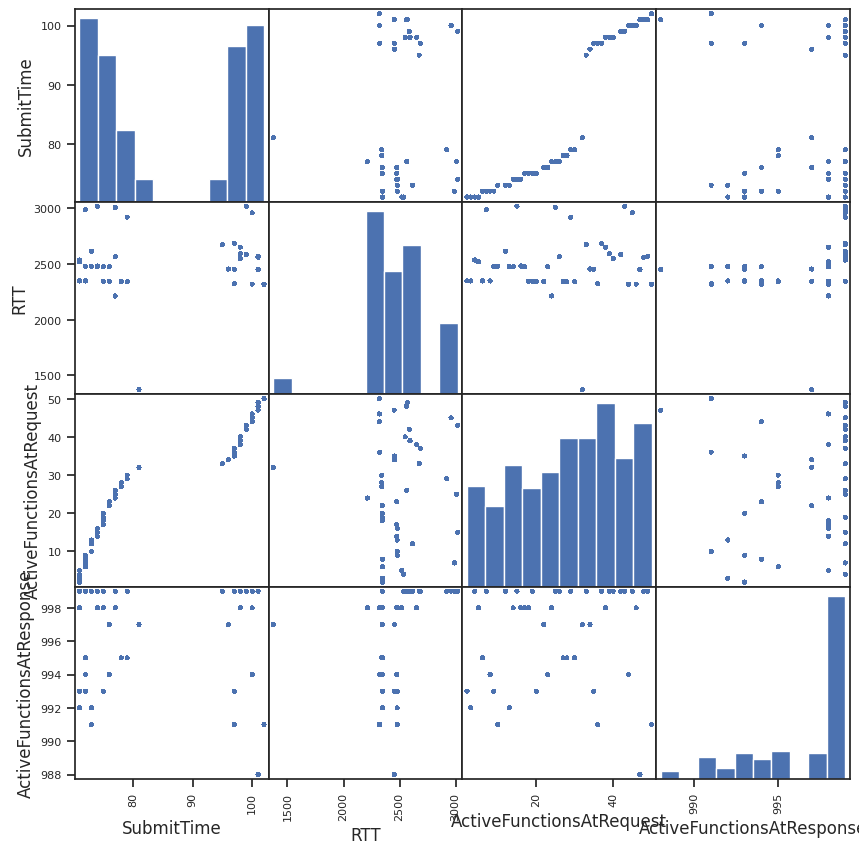

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

# Entropy features
entropy_features = ['SubmitTime', 'RTT', 'ActiveFunctionsAtRequest', 'ActiveFunctionsAtResponse'] 

# Generate entropy features
for feature in entropy_features:
    X[f'{feature}_entropy'] = dataset.groupby('IP')[feature].transform(lambda x: entropy(x.value_counts(normalize=True)))

# Create 4x4 grid of axes for scatter matrix plot   
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Plot scatter matrix of entropy features
pd.plotting.scatter_matrix(X[entropy_features], diagonal='hist', ax=axs)

# Show plot
plt.show()

### Entropy-Based Features

Entropy-based features provide insights into the diversity and distribution of categorical attributes within the dataset. These features utilize entropy to quantify the uncertainty or randomness associated with the occurrence of different categories within specific groups, such as IP addresses.

For each specified feature (SubmitTime, RTT, ActiveFunctionsAtRequest, ActiveFunctionsAtResponse), the entropy-based feature calculates the entropy value over time, offering a dynamic view of the diversity of categorical values associated with each IP address.

**Key Points:**

- **SubmitTime_entropy**: This feature captures the entropy of submission times, indicating the variability in the distribution of submission times for requests originating from each IP address. High entropy suggests a wide range of submission times, potentially reflecting diverse usage patterns or workload fluctuations.

- **RTT_entropy**: RTT entropy quantifies the diversity in Round-Trip Time (RTT) values observed across different requests originating from the same IP address. Higher entropy values indicate greater variability in RTT, which could be indicative of diverse network conditions, routing paths, or traffic patterns.

- **ActiveFunctionsAtRequest_entropy**: This feature assesses the entropy of the number of active functions at the time of request submission for each IP address. Higher entropy values suggest a wider range of active functions at the time of request, reflecting variability in workload or functional dependencies.

- **ActiveFunctionsAtResponse_entropy**: Similarly, this feature measures the entropy of the number of active functions at the time of response for each IP address. It provides insights into the diversity of active functions observed in the response phase, which can be indicative of dynamic workload changes or resource utilization patterns.

These entropy-based features enable network administrators to monitor the diversity and variability of categorical attributes over time, facilitating the identification of anomalous behavior, workload fluctuations, or emerging patterns within specific IP addresses. By tracking entropy trends, administrators can adapt network management strategies to ensure optimal performance, resource allocation, and anomaly detection.


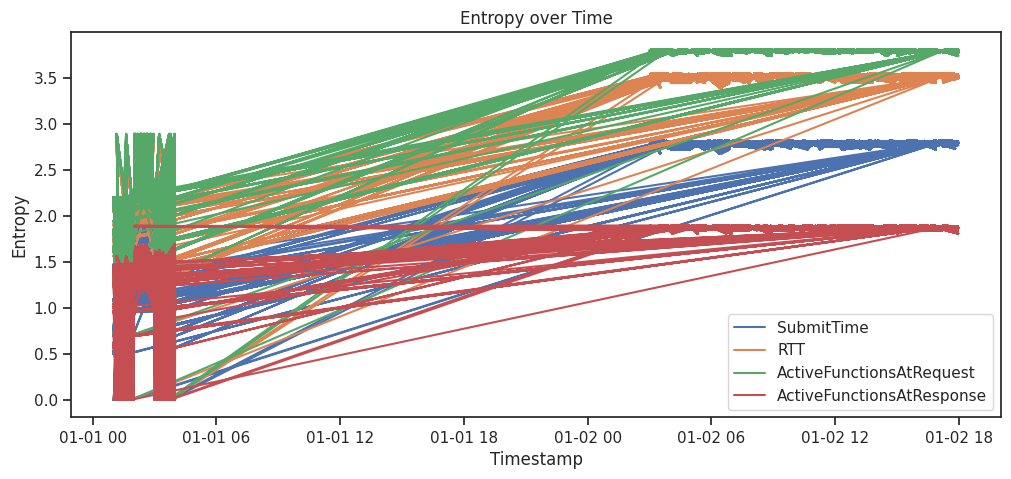

In [140]:
plt.figure(figsize=(12,5))

for feature in entropy_features:
    plt.plot(X['timestamp'], X[f'{feature}_entropy'], label=feature)

plt.xlabel('Timestamp')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()
plt.show()

## Autocorrelation Analysis of Entropy Features

- **SubmitTime Entropy:** The autocorrelation plot for SubmitTime entropy shows a significant positive correlation at lag 1, indicating a strong temporal dependency in the entropy values.
- **RTT Entropy:** The autocorrelation plot for RTT entropy reveals a strong positive correlation at lag 1 and some smaller positive correlations at subsequent lags, suggesting a persistent temporal pattern in RTT entropy.
- **ActiveFunctionsAtRequest Entropy:** The autocorrelation plot for ActiveFunctionsAtRequest entropy exhibits a positive correlation at lag 1 and diminishes gradually at higher lags, indicating a moderate temporal dependency.
- **ActiveFunctionsAtResponse Entropy:** The autocorrelation plot for ActiveFunctionsAtResponse entropy shows a similar pattern to ActiveFunctionsAtRequest entropy, with a positive correlation at lag 1 and diminishing correlations at higher lags.

Overall, these autocorrelation plots provide insights into the temporal dependencies present in the entropy-based features, which can be useful for understanding the underlying dynamics of the data and informing subsequent modeling decisions.


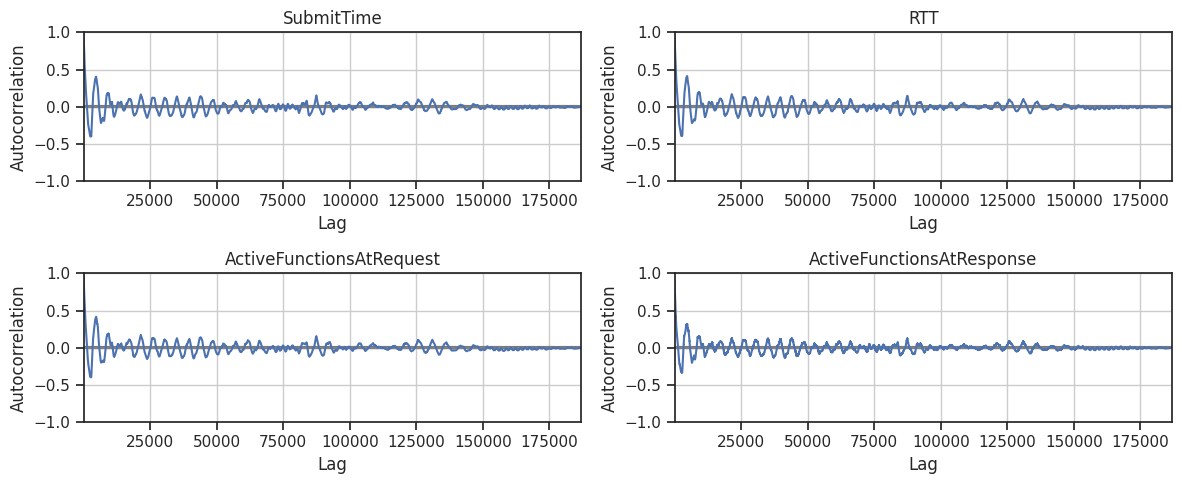

In [141]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12,5))
for i, feature in enumerate(entropy_features):
    plt.subplot(2, 2, i+1)
    autocorrelation_plot(X[f'{feature}_entropy'])
    plt.title(feature)
    
plt.tight_layout()

## Preprocessing Numerical Data

- **Function Trigger Encoding:** The 'functionTrigger' column was encoded using a mapping dictionary to convert categorical values into numerical representations. For example, 'notification' was mapped to 0 and 'other_value' to 1.

- **Imputation:** Missing values in numerical columns were imputed using a constant value strategy. NaN values were replaced with 0 to ensure consistency in feature representation.

- **Scaling:** Min-Max scaling was applied to normalize the numerical features within a specified range. This transformation ensures that all features have the same scale and are comparable across different ranges of values.

These preprocessing steps are essential for preparing the numerical data for machine learning models, ensuring that the data is in a suitable format for training and evaluation.


In [142]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

function_trigger_mapping = {'notification': 0, 'other_value': 1}

dataset['functionTrigger'] = dataset['functionTrigger'].map(function_trigger_mapping)

numerical_columns = ['Id', 'bot', 'FunctionId', 'functionTrigger', 'SubmitTime', 'RTT',
                     'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest',
                     'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket',
                     'vmmemorybucket']

# Impute NaN values with a specific value, such as 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
dataset[numerical_columns] = imputer.fit_transform(dataset[numerical_columns])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(dataset[numerical_columns])

### Data Splitting for Model Training and Evaluation

In preparing data for training machine learning models, a crucial step involves dividing the dataset into distinct subsets for training, validation, and testing. A common strategy is the 80-20 split, where 80% of the data is allocated for training and validation, while the remaining 20% is reserved for testing the model's performance.

Here's an outline of the typical data splitting process:

1. **Initial Division:**
   - Initially, the dataset is split into a training set (80%) and a testing set (20%) using the `test_size=0.2` parameter within the `train_test_split` function.

2. **Additional Splitting for Validation:**
   - Subsequently, the training set obtained from the initial split undergoes further division into a training subset (80% of the training set) and a validation subset (20% of the training set).
   - This ensures that approximately 64% of the original data is utilized for training, 16% for validation, and 20% for testing.

By employing this approach, the model benefits from being trained on a sizable dataset while also having distinct subsets for validating its performance during training and evaluating its ability to generalize on unseen data.


In [143]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Reshaping Input Data for LSTM

- **Timesteps:** Each sample in the input data represents a single timestep, indicating the sequential nature of the data. Here, the `timesteps` variable is set to 1, signifying that each sample consists of only one timestep.

- **Number of Features:** The number of features in the input data is determined by the shape of the scaled dataset (`X_scaled`). This value ensures compatibility with the LSTM input shape, facilitating efficient processing of the data.

- **Reshaping Training, Validation, and Testing Data:** The training (`X_train`), validation (`X_val`), and testing (`X_test`) datasets undergo reshaping to align with the LSTM input shape. This transformation converts the data into a three-dimensional array, with dimensions representing the number of samples, timesteps, and features.

By restructuring the input data in this manner, it becomes harmonized with the LSTM model architecture, enabling seamless training and evaluation processes.


In [144]:
# Reshape the input data to match the LSTM input shape
timesteps = 1  # Assuming each sample represents a single timestep
num_features = X_scaled.shape[1]  # Use the scaled dataset for reshaping
X_train = X_train.reshape(X_train.shape[0], timesteps, num_features)
X_val = X_val.reshape(X_val.shape[0], timesteps, num_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, num_features)

## Creating and Training the Bi-LSTM Model

- **Model Architecture:** The architecture of the model is established using the Keras `Sequential` API. It comprises a bidirectional LSTM layer with 64 units and ReLU activation function. The input shape is defined to match the reshaped input data, incorporating the number of timesteps and features.

- **Output Layer:** A dense layer with a single unit and sigmoid activation function is added as the output layer. This layer generates binary classification predictions.

- **Compilation:** For compilation, the model is configured with the Adam optimizer and binary cross-entropy loss function. The evaluation metric used is accuracy.

- **Early Stopping:** To mitigate overfitting, early stopping is employed with a patience setting of 3 epochs. During training, the validation loss is monitored, and training halts if the validation loss fails to improve for three consecutive epochs.

- **Training:** Training of the model is executed utilizing the `fit` method. The training dataset (`X_train` and `y_train`) is supplied, along with the validation dataset (`X_val` and `y_val`). Training occurs over 10 epochs with a batch size of 32.

By adhering to these steps, the bidirectional LSTM model is constructed, compiled, and trained on the provided data, with early stopping mechanisms in place to prevent overfitting.


In [145]:
# Create and train the bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=64, activation='relu'), input_shape=(timesteps, num_features)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=3, monitor='val_loss')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
3742/3742 [==============================] - 17s 4ms/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 1.4089e-05 - val_accuracy: 1.0000
Epoch 2/10
3742/3742 [==============================] - 14s 4ms/step - loss: 3.5180e-06 - accuracy: 1.0000 - val_loss: 5.0588e-07 - val_accuracy: 1.0000
Epoch 3/10
3742/3742 [==============================] - 14s 4ms/step - loss: 2.0951e-07 - accuracy: 1.0000 - val_loss: 5.7698e-08 - val_accuracy: 1.0000
Epoch 4/10
3742/3742 [==============================] - 15s 4ms/step - loss: 3.1379e-08 - accuracy: 1.0000 - val_loss: 1.3253e-08 - val_accuracy: 1.0000
Epoch 5/10
3742/3742 [==============================] - 14s 4ms/step - loss: 1.0542e-08 - accuracy: 1.0000 - val_loss: 8.2329e-09 - val_accuracy: 1.0000
Epoch 6/10
3742/3742 [==============================] - 15s 4ms/step - loss: 8.2904e-09 - accuracy: 1.0000 - val_loss: 8.1015e-09 - val_accuracy: 1.0000
Epoch 7/10
3742/3742 [==============================] - 15s 4ms/step - loss: 8.3529e-0

## Assessing Model Performance

- **Training History:** The model's training history, comprising metrics such as loss and accuracy recorded during training and validation across epochs, is retrieved.

- **Visualizing Loss:** Loss values observed during training and validation are graphed against the number of epochs. This graphical representation aids in evaluating the model's performance over the training period, indicating whether there are improvements or signs of overfitting.

- **Visualizing Accuracy:** Similarly, accuracy values attained during training and validation are plotted against the number of epochs. This visualization offers insights into how the model's accuracy progresses during both training and validation stages.

By analyzing these visualizations, one can ascertain the extent to which the model effectively learns from the data and discern any indications of overfitting or underfitting.


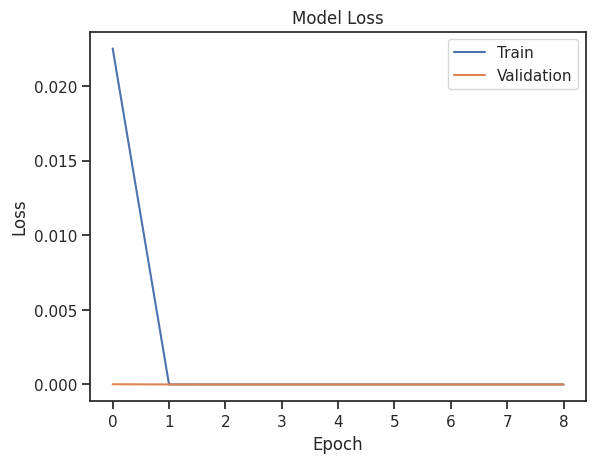

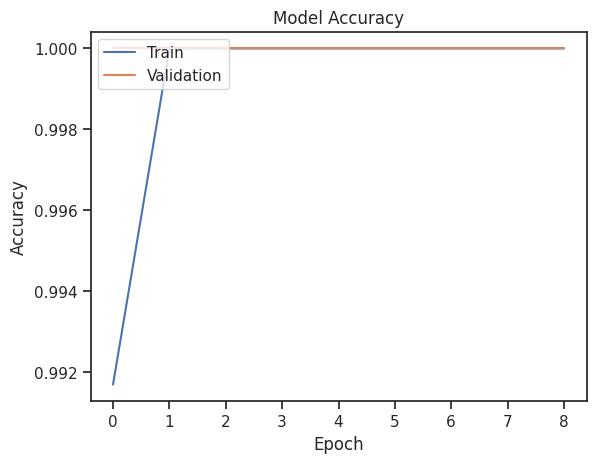

In [146]:
# Get training history 
history = model.history 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Making Predictions

- **Prediction:** Utilizing the trained bidirectional LSTM model, predictions are generated for the test set samples. These predictions provide binary labels indicating the presence or absence of a Denial-of-Service (DoW) attack.

- **Thresholding:** Following prediction generation, the predicted probabilities are subjected to thresholding at 0.5. This process converts the probabilities into binary predictions: probabilities exceeding 0.5 are classified as 1, signifying the detection of a DoW attack, while those below 0.5 are classified as 0, indicating the absence of a DoW attack.

These binary predictions serve as the basis for evaluating the model's performance in identifying DoW attacks within the test dataset.


In [147]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

1170/1170 [==============================] - 2s 2ms/step


## Evaluation Metrics Calculation

- **Accuracy:** The model's overall accuracy in predicting Denial-of-Service (DoW) attacks on the test set is computed using the `accuracy_score` function.

- **Confusion Matrix:** By employing the `confusion_matrix` function, a confusion matrix is generated. Key metrics derived from the confusion matrix include:
  - **True Positives (TP):** The count of instances correctly identified as DoW attacks.
  - **Actual DoW Attacks:** The total number of instances labeled as DoW attacks within the test set.
  - **Total Samples:** The overall number of samples present in the test set.

- **Detection Rate (Recall):** The detection rate, often referred to as recall, is determined as the ratio of true positives to the total number of actual DoW attacks.

## Results Display

- The computed accuracy and detection rate metrics are presented alongside the total sample count, actual DoW attacks count, and detected DoW attacks count within the test set.


In [148]:
# Assess the presence of DoW attacks
# Assuming y_test and y_pred are arrays of binary labels representing the ground truth and predictions, respectively
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
true_positives = conf_matrix[1, 1]  # Number of true positives
actual_dow_attacks = conf_matrix[1, :].sum()  # Total number of actual DoW attacks
num_samples = len(y_test)  # Total number of samples

# Calculate detection rate (recall)
detection_rate = true_positives / actual_dow_attacks

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Detection Rate: {detection_rate:.2%}")
print(f"Total samples: {num_samples}")
print(f"Actual DoW attacks: {actual_dow_attacks}")
print(f"Detected DoW attacks: {true_positives}")


Accuracy: 1.00
Detection Rate: 100.00%
Total samples: 37418
Actual DoW attacks: 26257
Detected DoW attacks: 26257


## Detection of DoW Attacks

A bar plot is used to visualize the detection of Denial-of-Service (DoW) attacks on the test set. The plot displays the following categories:

- **Total Samples:** Total number of samples in the test set.
- **Actual DoW Attacks:** Total number of instances labeled as DoW attacks in the test set.
- **Detected DoW Attacks:** Number of instances correctly predicted as DoW attacks by the model.

The plot provides a visual comparison of the total number of samples, actual DoW attacks, and detected DoW attacks, highlighting the model's performance in identifying DoW attacks.



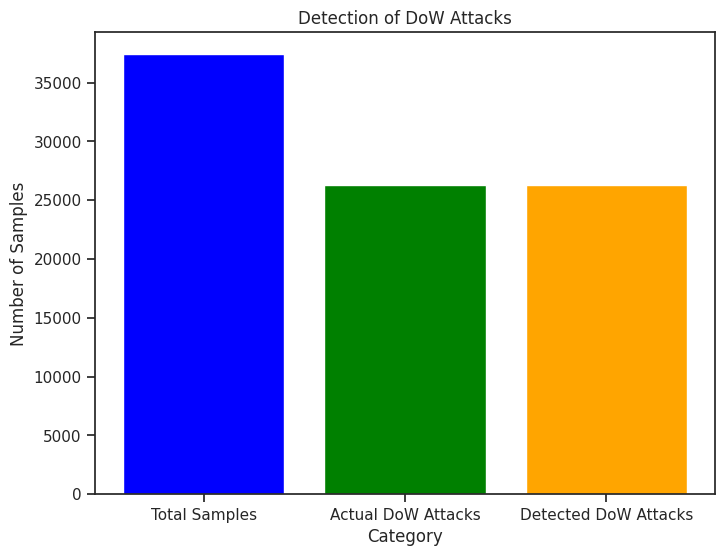

In [149]:
# Plot
labels = ['Total Samples', 'Actual DoW Attacks', 'Detected DoW Attacks']
values = [num_samples, actual_dow_attacks, true_positives]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Detection of DoW Attacks')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()


## Evaluation Metrics

To gauge the effectiveness of the model in identifying Denial-of-Service (DoW) attacks, the following evaluation metrics are computed:

- **Precision:** Precision quantifies the ratio of correctly predicted positive instances to the total positive predictions made by the model.
- **Recall:** Recall, also referred to as sensitivity, denotes the proportion of true positive predictions relative to all actual positive instances within the test dataset.
- **F1 Score:** The F1 score, calculated as the harmonic mean of precision and recall, offers a consolidated metric to assess the balance between precision and recall.
- **ROC AUC Score:** The Receiver Operating Characteristic Area Under the Curve (ROC AUC) score evaluates the model's ability to differentiate between positive and negative instances across various threshold values.

These computed metrics provide valuable insights into the model's accuracy, completeness, and discriminatory power in identifying DoW attacks.


In [150]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC Score: 1.00


## Receiver Operating Characteristic (ROC) Curve

The ROC curve offers a visual depiction of a binary classification model's performance across various threshold settings. It plots the True Positive Rate (TPR), also known as sensitivity, against the False Positive Rate (FPR), which is calculated as 1 minus specificity, at different threshold values.

- **True Positive Rate (TPR):** This metric represents the proportion of correctly predicted positive instances among all actual positive instances in the test set.
- **False Positive Rate (FPR):** The FPR indicates the proportion of incorrectly predicted positive instances among all actual negative instances in the test set.

The ROC curve illustrates the trade-off between sensitivity and specificity. Ideally, a perfect classifier would yield a curve that traverses the top-left corner of the plot, indicating high TPR and low FPR across all threshold values.

The area under the ROC curve (ROC AUC) serves as a quantitative measure of the model's overall performance: a higher ROC AUC score signifies better discrimination ability.


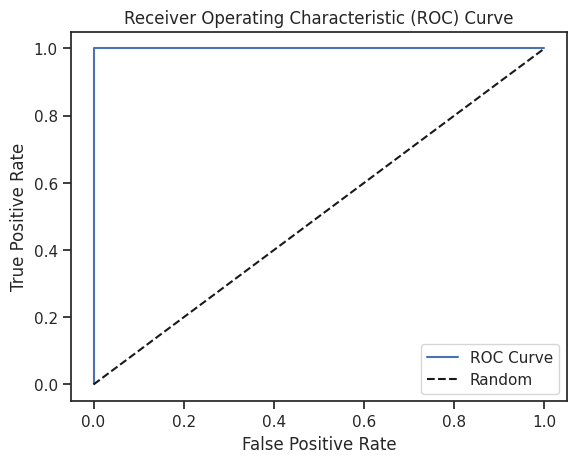

In [151]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()